In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
# from dataprep import eda
from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')


In [190]:
df = pd.read_csv('Boston_Housing.csv')

# Nettoyage / Analyse

In [191]:
df = df.drop(df.columns[-1], axis=1)

There are 14 attributes in each case of the dataset. They are:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

- CRIM : Taux de criminalité par habitant dans la ville
- ZN : Proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : Proportion d'acres dédiés aux activités non commerciales par ville
- CHAS : Variable factice du fleuve Charles (1 si le terrain borde le fleuve, 0 sinon)
- NOX : Concentration d'oxydes d'azote (en parties par 10 millions)
- RM : Nombre moyen de pièces par logement
- AGE : Proportion d'unités occupées par le propriétaire construites avant 1940
- DIS : Distances pondérées vers cinq centres d'emploi de Boston
- RAD : Indice d'accessibilité aux autoroutes radiales
- TAX : Taux d'imposition foncière à pleine valeur par tranche de 10 000 dollars
- PTRATIO : Ratio élèves-enseignants par ville
- B : 1000 * (Bk - 0.63)^2, où Bk est la proportion de personnes noires par ville
- LSTAT : Pourcentage de la population à statut socio-économique faible
- MEDV : Valeur médiane des logements occupés par leur propriétaire en milliers de dollars

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [193]:
# report = eda.create_report(df)
# report.show_browser()
# report.save('analyse_report') 

In [194]:
# profile = ProfileReport(df, title="Profiling Report")

In [195]:
# profile.to_file("Analyse_report.html")

In [196]:
print(df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

ZN a 73.5% de valeurs égales à 0 (il s'agit d'une variable conditionnelle, pour les lot de plus de 25 000 sqft).   
CHAS a 93% de valeurs égales à 0, il s'agit d'une variable catégorielle.

In [197]:
np.shape(df)

(506, 14)

Le prix médian semble être plafonné à 50. On a testé de supprimé les lignes où MEDV est supérieure ou égale à 50 mais cela diminue la performance du modèle. On décide alors de conserver ces lignes.

In [198]:
# df = df[~(df['MEDV'] >= 50.0)]
# print(np.shape(df))

<Axes: >

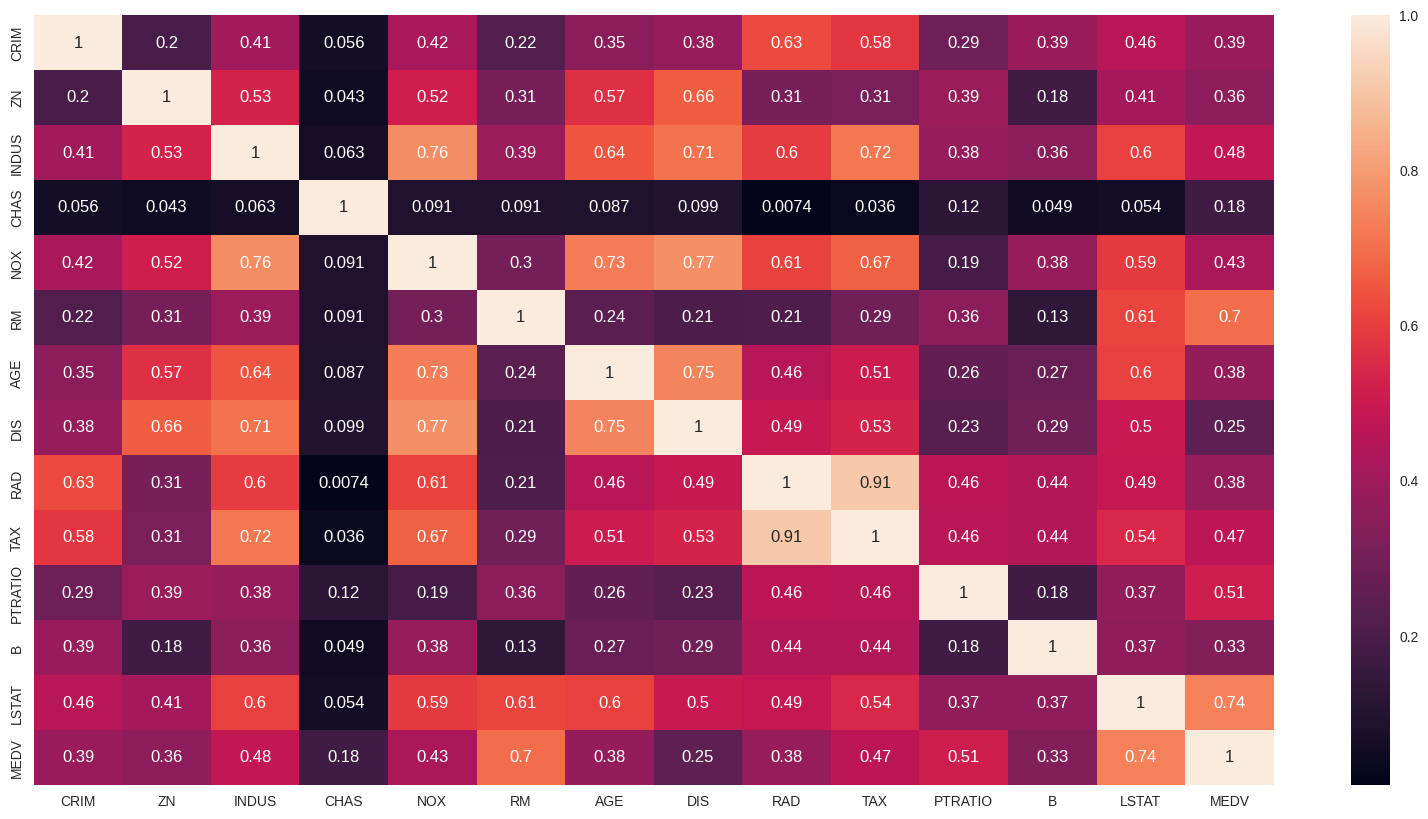

In [199]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

D'après la matrice de corrélation de :
- TAX et RAD très corrélées l'une à l'autre (0.91)
- RM, LSAT, PTRATIO très corrélées à MEDV (> 0.50)
- INDUS, NOX, TAX corrélation moyenne à MEDV (entre 0.5 et 0.4)
- CRIM, ZN, AGE, RAD peu corrélés à MEDV (entre 0.4 et 0.35)
- CHAS, DIS B très peu corrélés à MEDV (<0.35)

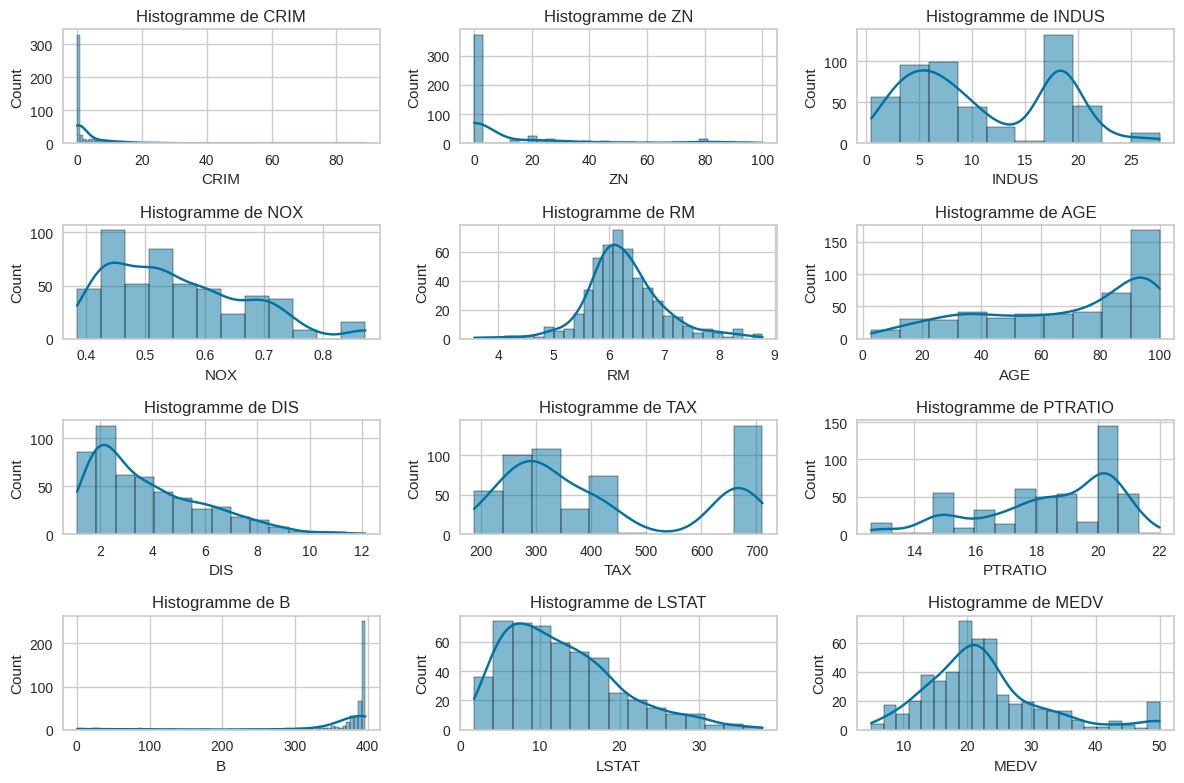

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables à inclure dans les histogrammes
variables = ['CRIM', 'ZN', 'INDUS' ,'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Calcul du nombre de lignes et de colonnes pour la grille
num_rows = 4  # Nombre de lignes
num_cols = 3  # Nombre de colonnes

# Création de la figure et des sous-tracés
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Aplatir la liste d'axes si nécessaire
if num_rows == 1:
    axes = [axes]

# Parcourir chaque variable et attribuer l'histogramme à un sous-tracé
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]

    sns.histplot(df[variable], ax=ax, kde=True)  # Trace l'histogramme avec la courbe
    ax.set_title(f'Histogramme de {variable}')  # Définir le titre du sous-tracé

# Supprimer les sous-tracés non utilisés
for i in range(len(variables), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row][col])

# Ajuster l'espacement entre les sous-tracés
fig.tight_layout()

# Afficher la figure
plt.show()


In [201]:
df.head(1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0


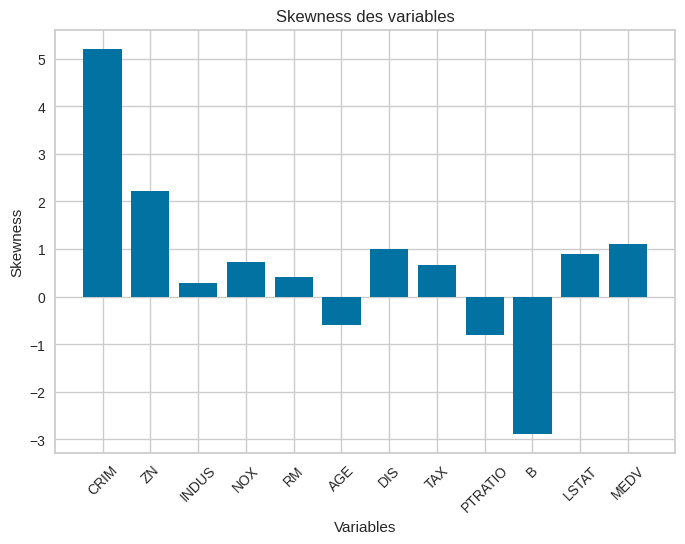

In [202]:
import scipy.stats as stats

data = df[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']]

skewness = data.apply(lambda x: stats.skew(x)).to_dict()

variables = list(skewness.keys())
values = list(skewness.values())

plt.bar(variables, values)
plt.xlabel('Variables')
plt.ylabel('Skewness')
plt.title('Skewness des variables')
plt.xticks(rotation=45)
plt.show()


# Modélisation

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



## Choix du modèle 

### Tests du modèles naifs

In [204]:
df_score=pd.DataFrame(columns = ["reg_lin", "lasso", "ridge", "decision_tree", "random_forest"])

#### Regression linéaire naifs : 

In [205]:
Xn=df.drop("MEDV", axis=1)
yn=df["MEDV"]
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.2, random_state=42)

modele_naif_reg_lin = linear_model.LinearRegression()
modele_naif_reg_lin.fit(Xn_train, yn_train )

modele_naif_lasso = linear_model.Lasso(alpha=1)
modele_naif_lasso.fit(Xn_train, yn_train )

modele_naif_ridge = linear_model.Ridge(alpha=1)
modele_naif_ridge.fit(Xn_train, yn_train )

# scoring sur X_test
df_score.loc[0, "reg_lin"] = modele_naif_reg_lin.score(Xn_test, yn_test)
df_score.loc[0, "lasso"] = modele_naif_lasso.score(Xn_test, yn_test)
df_score.loc[0, "ridge"] = modele_naif_ridge.score(Xn_test, yn_test)

print(df_score)


    reg_lin     lasso     ridge decision_tree random_forest
0  0.668759  0.667145  0.666222           NaN           NaN


#### Decision Tree

In [206]:
decision_tree_naif = DecisionTreeRegressor(random_state=42)
decision_tree_naif.fit(Xn_train, yn_train )

df_score.loc[0, "decision_tree"] = decision_tree_naif.score(Xn_test, yn_test)
print(df_score)


    reg_lin     lasso     ridge decision_tree random_forest
0  0.668759  0.667145  0.666222      0.857963           NaN


#### Random Forest 

In [207]:
random_forest_naif = RandomForestRegressor()
random_forest_naif.fit(Xn_train, yn_train )

df_score.loc[0, "random_forest"] = random_forest_naif.score(Xn_test, yn_test)
print(df_score)

    reg_lin     lasso     ridge decision_tree random_forest
0  0.668759  0.667145  0.666222      0.857963      0.880358


#### On choisi le modèle Random Forest

In [208]:
numerical_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', numerical_transformer, numerical_features),
    ], remainder="passthrough"
)

In [209]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [210]:
model = RandomForestRegressor()

In [211]:
pipe_rf = Pipeline([
     ('prep', preprocessor),
     ('model', model)
])

# Entrainement sur X_train
trained_model = pipe_rf.fit(X_train,y_train)

# scoring sur X_test
print(trained_model.score(X_test, y_test))

0.8781132296058579


### Pycaret

In [212]:
# from pycaret.regression import *
# s = setup(df, target = 'MEDV', preprocess=True)

Étape de prétraitement :  
  
**numerical_imputer** : Cette étape utilise SimpleImputer pour remplacer les valeurs manquantes dans les variables numériques sélectionnées (CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT).  

**categorical_imputer** : Cette étape utilise SimpleImputer avec la stratégie "most_frequent" pour remplacer les valeurs manquantes dans les variables catégorielles (aucune variable catégorielle n'a été sélectionnée).   

Il n'y a pas de valeurs manquantes, j'enlève donc l'étape de pretraitement auto

#### Meilleurs modèles pycaret

In [213]:
# best_model = compare_models()
# print(best_model)

In [214]:
# s = setup(df, target = 'MEDV', preprocess=False)
# models_to_compare = ['gbr', 'catboost', 'rf', 'et']
# best = compare_models(include=models_to_compare)

CatBoostRegressor, Extra Trees Regressor et Gradient Boosting Regressor sont les 3 meilleures modèles. 

## Gradient Boosting Regresor

In [215]:
from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor()

In [216]:
pipe_gbr= Pipeline([
     ('prep', preprocessor),
     ('model', model_gbr)
])

# Entrainement sur X_train
trained_model_gbr = pipe_gbr.fit(X_train,y_train)

# scoring sur X_test
print(trained_model_gbr.score(X_test, y_test))

0.9151134798842443


## Feature Importance

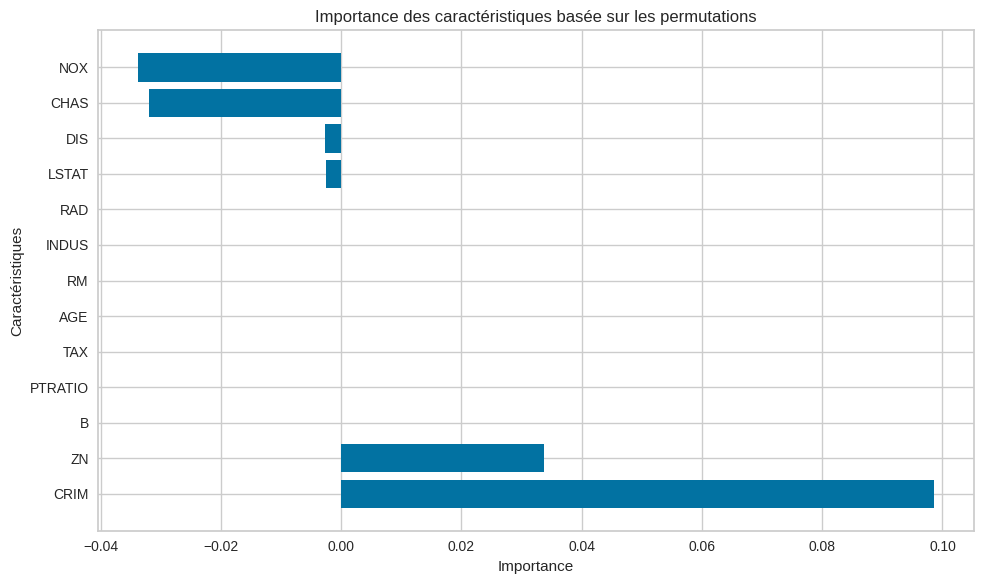

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Calcul de l'importance des caractéristiques par permutations
result = permutation_importance(model_gbr, X, y, n_repeats=10, random_state=42)

# Récupération des valeurs d'importance et des noms de caractéristiques
importance = result.importances_mean
feature_names = X.columns

# Tri des valeurs d'importance dans l'ordre décroissant
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques basée sur les permutations')
plt.tight_layout()
plt.show()


### Importance des caractéritiques basée sur les impuretés

In [218]:
# Récupération de l'importance des caractéristiques
feature_importance = model_gbr.feature_importances_

# Tri des valeurs d'importance dans l'ordre croissant
sorted_importance = sorted(zip(X.columns, feature_importance), key=lambda x: x[1])

# Affichage des résultats dans l'ordre croissant
for feature_name, importance in sorted_importance:
    print(f"{feature_name}: {importance}")



B: 0.0001766731358768385
ZN: 0.00048822471958496496
LSTAT: 0.0019461302983811758
INDUS: 0.004102150443546838
TAX: 0.009186210019270134
DIS: 0.011613746496647303
RM: 0.015255643273112688
CRIM: 0.0285417577665015
CHAS: 0.030588487312547256
RAD: 0.03587606077375874
AGE: 0.07206665103610937
PTRATIO: 0.3744076304714105
NOX: 0.4157506342532526


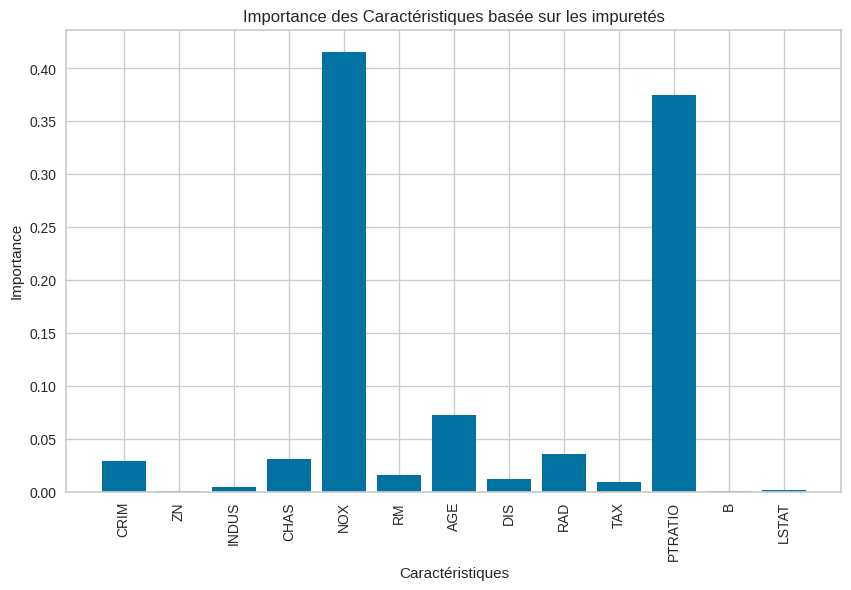

In [219]:
# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des Caractéristiques basée sur les impuretés')
plt.show()

En croisant ces infos avec la matrice de corrélation, on décide de supprimer les features : 
- ZN (car conditionnelle au lot de plus de 25000 sqft)
- B

### SHAP

[[ 0.90192147  0.74129516  0.         ...  0.          0.02277816
   0.        ]
 [ 0.90192147 -0.28828145  0.         ...  0.          0.00855675
   0.        ]
 [ 0.90192147 -0.28828145  0.         ...  0.         -0.08221347
   0.        ]
 ...
 [ 0.90192147 -0.28828145  0.         ...  0.          0.02277816
   0.        ]
 [ 0.90192147 -0.28828145  0.         ...  0.          0.02277816
   0.        ]
 [ 0.90192147 -0.28828145  0.         ...  0.          0.02277816
   0.        ]]


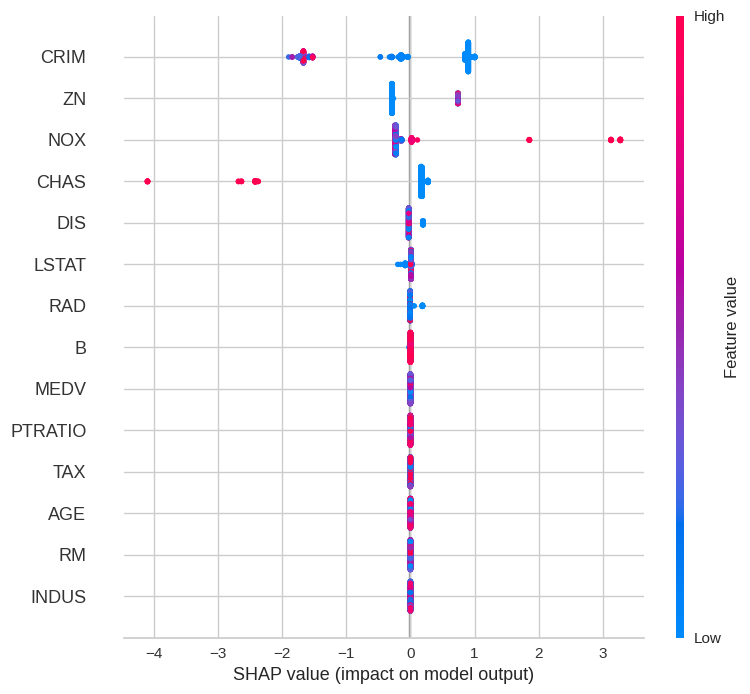

In [220]:
# Initialiser l'explainer SHAP avec les données et le modèle
explainer = shap.Explainer(model_gbr, df)

# Calculer les valeurs SHAP pour toutes les caractéristiques
shap_values = explainer.shap_values(df)

# Afficher les valeurs SHAP
print(shap_values)

# Tracer un graphique des importances des caractéristiques
shap.summary_plot(shap_values, df)

# Afficher le graphique
plt.show()

### Suppression des features ZN et B

In [239]:
X = df.drop(['MEDV', 'B'], axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Nouveau pipeline (sans les features supprimées)

In [240]:
numerical_features2 = ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'INDUS', 'ZN']
numerical_transformer = StandardScaler()

preprocessor2 = ColumnTransformer(
    transformers=[
        
        ('num', numerical_transformer, numerical_features2),
    ], remainder="passthrough"
)

### Test du nouveau modèle

In [241]:
pipe_gbr2 = Pipeline([
     ('prep', preprocessor2),
     ('model', model_gbr)
])

# Entrainement sur X_train
trained_model_gbr2 = pipe_gbr2.fit(X_train,y_train)

# scoring sur X_test
print(trained_model_gbr2.score(X_test, y_test))

0.9150534693020792


Hyperparamètres par défaut :  
- n_estimators : 100
- learning_rate : 0.1
- max_depth : 3
- min_samples_split : 2
- min_samples_leaf : 1
- max_features : None

## Meilleur modèle

### Recherche des meilleurs hyperparamètres (Optuna)

In [242]:
from sklearn.metrics import mean_squared_error
import optuna

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [244]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    subsample = trial.suggest_float('subsample', 0.1, 1.0)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        subsample=subsample
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    return r2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Meilleurs hyperparamètres:", study.best_params)
print("R2 avec les meilleurs hyperparamètres:", study.best_value)

[I 2023-06-13 15:13:51,095] A new study created in memory with name: no-name-6617f107-ca8b-45c1-b8b5-adec362a57cc
[I 2023-06-13 15:13:51,223] Trial 0 finished with value: 0.7903138881027129 and parameters: {'learning_rate': 0.049598531588381255, 'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': None, 'subsample': 0.12985868023967445}. Best is trial 0 with value: 0.7903138881027129.
[I 2023-06-13 15:13:51,363] Trial 1 finished with value: 0.8714472234237685 and parameters: {'learning_rate': 0.08051654137202274, 'n_estimators': 200, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'subsample': 0.8715069758277137}. Best is trial 1 with value: 0.8714472234237685.
[I 2023-06-13 15:13:51,990] Trial 2 finished with value: 0.8883983836787186 and parameters: {'learning_rate': 0.07473651057579635, 'n_estimators': 800, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2', 'sub

Meilleurs hyperparamètres: {'learning_rate': 0.03704759602814329, 'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'subsample': 0.9779499997661716}
R2 avec les meilleurs hyperparamètres: 0.9298225521193376


Meilleurs hyperparamètres: {'n_estimators': 579, 'learning_rate': 0.0731645148741222, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'auto'}

### Entrainement du modèle avec les meilleurs hyperparamètres défini avec Optuna

In [227]:
# Création du nouveau modèle avec les meilleurs hyperparamètres
best_params = study.best_params
model_gbr_best = GradientBoostingRegressor(**best_params)

# Création du pipeline avec le nouveau modèle et le préprocesseur
pipe_gbr2 = Pipeline([
     ('prep', preprocessor2),
     ('model', model_gbr_best)
])

# Entraînement sur X_train
trained_model_gbr2 = pipe_gbr2.fit(X_train, y_train)

# Scoring sur X_test
print(trained_model_gbr2.score(X_test, y_test))


0.9343146230193109


In [233]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Prédiction sur les données de test
y_pred = trained_model_gbr2.predict(X_test)

# Calcul du coefficient de détermination (R^2)
r2 = r2_score(y_test, y_pred)

# Calcul du Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calcul de l'erreur absolue moyenne (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Affichage des métriques
print("R2:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


R2: 0.9343146230193109
MSE: 4.816957192305928
RMSE: 2.1947567501447462
MAE: 1.7226857745653252


### Courbe d'apprentissage

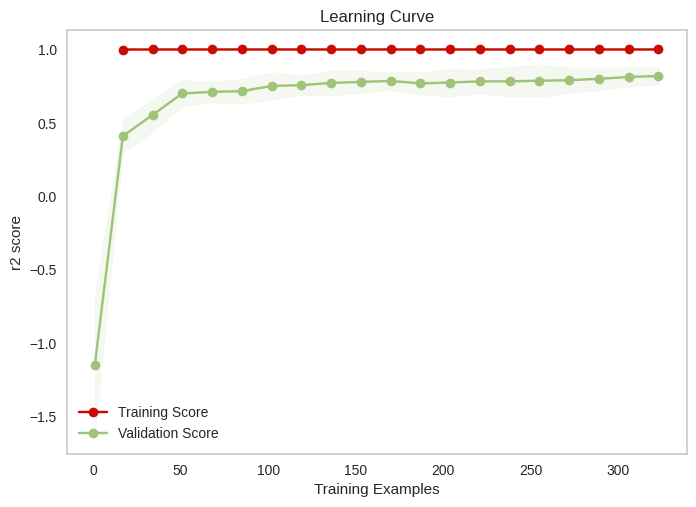

In [234]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.001, 1.0, 20), cv=5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("r2 score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
    
    plt.legend(loc="best")
    plt.show()

# Utilisation de la fonction pour tracer les courbes d'apprentissage
plot_learning_curve(trained_model_gbr2, X_train, y_train)


### Comparaison des valeurs prédites et des vraies valeurs

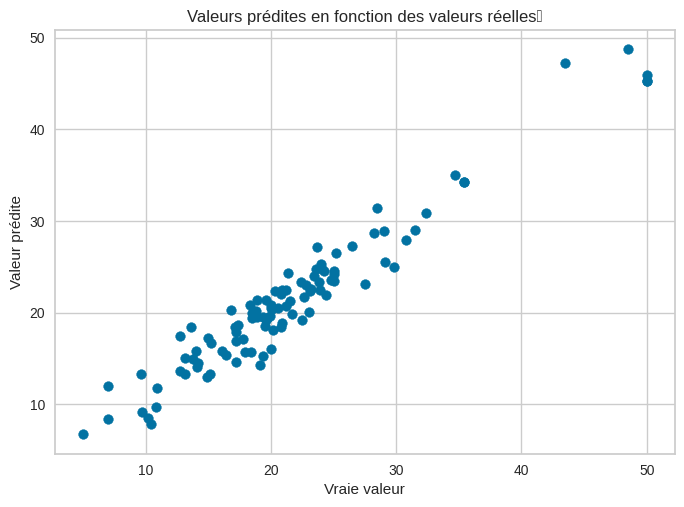

In [235]:
import matplotlib.pyplot as plt

# Obtenir les valeurs prédites du modèle
y_pred = trained_model_gbr2.predict(X_test)

# Tracer le graphique
plt.scatter(y_test, y_pred)
plt.xlabel('Vraie valeur')
plt.ylabel('Valeur prédite')
plt.title('Valeurs prédites en fonction des valeurs réelles​')
plt.show()


In [245]:
trained_model_gbr2

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CRIM', 'NOX', 'RM', 'AGE',
                                                   'DIS', 'TAX', 'PTRATIO',
                                                   'LSTAT', 'INDUS', 'ZN'])])),
                ('model', GradientBoostingRegressor())])